In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *


def iso_normalizer(t) :
    iso = 0.0
    if np.sum(t) > 0.0 :
        iso = np.sum(t[80: 80+25]) / np.sum(t)
    
    return iso

def cut_normalizer(t) :
    cuts = np.concatenate([np.zeros(205), np.array([1.0])])
    if np.sum(t) > 0.0 :
        cuts = t / np.sum(t)
    
    return cuts

def plot_gan_logo(pwm, score, sequence_template=None, figsize=(12, 3), width_ratios=[1, 7], logo_height=1.0, plot_start=0, plot_end=164) :

    #Slice according to seq trim index
    pwm = pwm[plot_start: plot_end, :]
    sequence_template = sequence_template[plot_start: plot_end]

    pwm += 0.0001
    for j in range(0, pwm.shape[0]) :
        pwm[j, :] /= np.sum(pwm[j, :])

    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = 2 - entropy

    fig = plt.figure(figsize=figsize)

    gs = gridspec.GridSpec(1, 2, width_ratios=[width_ratios[0], width_ratios[-1]])

    ax2 = plt.subplot(gs[0])
    ax3 = plt.subplot(gs[1])

    plt.sca(ax2)
    plt.axis('off')


    annot_text = '\nScore = ' + str(round(score, 4))

    ax2.text(0.99, 0.5, annot_text, horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes, color='black', fontsize=12, weight="bold")

    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i] * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            color = None
            if sequence_template[j] != 'N' :
                color = 'black'

            if ii == 0 :
                letterAt(nt, j + 0.5, height_base, nt_prob * logo_height, ax3, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                letterAt(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax3, color=color)

    plt.sca(ax3)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, 2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    ax3.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)


    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    plt.show()

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:
#Load APA native data (APADB)

plasmid_df = pd.read_csv('../leslie_apadb_data_wider_v2.csv', sep=',')

print("len(plasmid_df) = " + str(len(plasmid_df)))

#Filter data

plasmid_df = plasmid_df.loc[plasmid_df['site_type'].isin(['UTR3', 'Extension'])].copy().reset_index(drop=True)

#plasmid_df = plasmid_df.query("pas != -1").copy().reset_index(drop=True)
plasmid_df = plasmid_df.loc[plasmid_df['pas'].isin([0, 1, 2])].copy().reset_index(drop=True)

print("len(plasmid_df) = " + str(len(plasmid_df)) + " (filtered)")


len(plasmid_df) = 59731
len(plasmid_df) = 31060 (filtered)


In [3]:
#Make generators

valid_set_size = 0.05
test_set_size = 0.05

batch_size = 32

#Generate training and test set indexes
plasmid_index = np.arange(len(plasmid_df), dtype=np.int)

plasmid_train_index = plasmid_index[:-int(len(plasmid_df) * (valid_set_size + test_set_size))]
plasmid_valid_index = plasmid_index[plasmid_train_index.shape[0]:-int(len(plasmid_df) * test_set_size)]
plasmid_test_index = plasmid_index[plasmid_train_index.shape[0] + plasmid_valid_index.shape[0]:]

print('Training set size = ' + str(plasmid_train_index.shape[0]))
print('Validation set size = ' + str(plasmid_valid_index.shape[0]))
print('Test set size = ' + str(plasmid_test_index.shape[0]))


data_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {'df' : plasmid_df},
        batch_size=batch_size,
        inputs = [
            {
                'id' : 'seq',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : iso.SequenceExtractor('wide_seq_ext', start_pos=175 - 61, end_pos=175 - 61 + 128),
                'encoder' : iso.OneHotEncoder(seq_length=128),
                'dim' : (1, 128, 4),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'dummy_output',
                'source_type' : 'zeros',
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [],
        shuffle = True if gen_id == 'train' else False
    ) for gen_id, idx in [('all', plasmid_index), ('train', plasmid_train_index), ('valid', plasmid_valid_index), ('test', plasmid_test_index)]
}


Training set size = 27954
Validation set size = 1553
Test set size = 1553


In [4]:
x_train = np.concatenate([data_gens['train'][i][0][0] for i in range(len(data_gens['train']))], axis=0)
x_test = np.concatenate([data_gens['test'][i][0][0] for i in range(len(data_gens['test']))], axis=0)

print(x_train.shape)
print(x_test.shape)


(27936, 1, 128, 4)
(1536, 1, 128, 4)


In [5]:

def make_gen_resblock(n_channels=64, window_size=3, stride=1, dilation=1, group_ix=0, layer_ix=0) :

    #Initialize res block layers
    batch_norm_0 = BatchNormalization(name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x))
    
    deconv_0 = Conv2DTranspose(n_channels, (1, window_size), strides=(1, stride), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_deconv_0')

    batch_norm_1 = BatchNormalization(name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=(1, dilation), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_deconv_0 = Conv2DTranspose(n_channels, (1, 1), strides=(1, stride), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_deconv_0')
    
    skip_1 = Lambda(lambda x: x[0] + x[1], name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    #Execute res block
    def _resblock_func(input_tensor) :
        
        batch_norm_0_out = batch_norm_0(input_tensor)
        relu_0_out = relu_0(batch_norm_0_out)
        deconv_0_out = deconv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(deconv_0_out)
        relu_1_out = relu_1(batch_norm_1_out)
        conv_1_out = conv_1(relu_1_out)
        
        skip_deconv_0_out = skip_deconv_0(input_tensor)

        skip_1_out = skip_1([conv_1_out, skip_deconv_0_out])
        
        return skip_1_out

    return _resblock_func

#Decoder Model definition
def load_decoder_resnet(seq_length=128, latent_size=100) :

    #Generator network parameters
    window_size = 3
    
    strides = [2, 2, 2, 2, 2, 1]
    dilations = [1, 1, 1, 1, 1, 1]
    channels = [512, 256, 128, 64, 32, 32]
    initial_length = 4
    n_resblocks = len(strides)

    #Policy network definition
    policy_dense_0 = Dense(initial_length * channels[0], activation='linear', kernel_initializer='glorot_normal', name='policy_generator_dense_0')
    policy_dense_0_reshape = Reshape((1, initial_length, channels[0]))
    
    curr_length = initial_length
    
    resblocks = []
    for layer_ix in range(n_resblocks) :
        resblocks.append(make_gen_resblock(n_channels=channels[layer_ix], window_size=window_size, stride=strides[layer_ix], dilation=dilations[layer_ix], group_ix=0, layer_ix=layer_ix))
    
    final_conv = Conv2D(4, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_final_conv')
    
    def _generator_func(seed_input) :
        
        policy_dense_0_out = policy_dense_0_reshape(policy_dense_0(seed_input))
        
        #Connect group of res blocks
        output_tensor = policy_dense_0_out

        #Res block group 0
        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks[layer_ix](output_tensor)

        #Final conv out
        final_conv_out = final_conv(output_tensor)
        
        return final_conv_out

    return _generator_func


In [6]:
from keras.layers.pooling import _GlobalPooling2D

class GlobalSumPooling2D(_GlobalPooling2D):
    def call(self, inputs):
        if self.data_format == 'channels_last':
            return K.sum(inputs, axis=[1, 2])
        else:
            return K.sum(inputs, axis=[2, 3])


def make_disc_resblock_pooled(n_channels=64, window_size=3, dilation=1, drop_rate=0.0, group_ix=0, layer_ix=0) :

    #Initialize res block layers
    batch_norm_0 = BatchNormalization(name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')
    
    relu_0 = Lambda(lambda x: K.relu(x))

    conv_0 = Conv2D(n_channels, (1, window_size), dilation_rate=(1, dilation), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = BatchNormalization(name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')
    
    relu_1 = Lambda(lambda x: K.relu(x))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=(1, dilation), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')
    
    pool_1 = AveragePooling2D(pool_size=(1, 2))
    
    drop_1 = Dropout(drop_rate, name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_drop_1')
    
    skip_conv_0 = Conv2D(n_channels, (1, 1), dilation_rate=(1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_conv_0')
    
    skip_pool_0 = AveragePooling2D(pool_size=(1, 2))

    skip_1 = Lambda(lambda x: x[0] + x[1], name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')
    
    #Execute res block
    def _resblock_func(input_tensor) :
        
        batch_norm_0_out = batch_norm_0(input_tensor)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out)
        relu_1_out = relu_1(batch_norm_1_out)
        conv_1_out = conv_1(relu_1_out)
        pool_1_out = pool_1(conv_1_out)
        
        skip_conv_0_out = skip_conv_0(input_tensor)
        skip_pool_0_out = skip_pool_0(skip_conv_0_out)

        skip_1_out = skip_1([pool_1_out, skip_pool_0_out])
        
        if drop_rate > 0.0 :
            skip_1_out = drop_1(skip_1_out)
        
        return skip_1_out

    return _resblock_func

def make_disc_resblock(n_channels=64, window_size=3, dilation=1, drop_rate=0.0, group_ix=0, layer_ix=0) :

    #Initialize res block layers
    batch_norm_0 = BatchNormalization(name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')
    
    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_0 = Conv2D(n_channels, (1, window_size), dilation_rate=(1, dilation), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = BatchNormalization(name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')
    
    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=(1, dilation), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')
    
    drop_1 = Dropout(drop_rate, name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_drop_1')
    
    skip_conv_0 = Conv2D(n_channels, (1, 1), dilation_rate=(1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_conv_0')
    
    skip_1 = Lambda(lambda x: x[0] + x[1], name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')
    
    #Execute res block
    def _resblock_func(input_tensor) :
        
        batch_norm_0_out = batch_norm_0(input_tensor)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out)
        relu_1_out = relu_1(batch_norm_1_out)
        conv_1_out = conv_1(relu_1_out)
        
        skip_conv_0_out = skip_conv_0(input_tensor)

        skip_1_out = skip_1([conv_1_out, skip_conv_0_out])
        
        if drop_rate > 0.0 :
            skip_1_out = drop_1(skip_1_out)
        
        return skip_1_out

    return _resblock_func

#GAN Discriminator Model definition
def load_encoder_resnet(seq_length=128, latent_size=100) :

    '''downsamples = [False, False, True, True, True]
    dilations = [1, 1, 1, 1, 1]
    channels = [32, 32, 64, 128, 256]
    window_sizes = [7, 7, 3, 3, 3]
    drop_outs = [0.0, 0.0, 0.0, 0.0, 0.0]'''
    
    downsamples = [False, False, True, True]
    dilations = [1, 1, 1, 1]
    channels = [32, 32, 64, 128]
    window_sizes = [7, 7, 3, 3]
    drop_outs = [0.0, 0.0, 0.0, 0.0]
    
    n_resblocks = len(dilations)

    policy_conv_0 = Conv2D(channels[0], (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_conv_0')
    
    resblocks = []
    for layer_ix in range(n_resblocks) :
        if downsamples[layer_ix] :
            resblocks.append(make_disc_resblock_pooled(n_channels=channels[layer_ix], window_size=window_sizes[layer_ix], dilation=dilations[layer_ix], drop_rate=drop_outs[layer_ix], group_ix=0, layer_ix=layer_ix))
        else :
            resblocks.append(make_disc_resblock(n_channels=channels[layer_ix], window_size=window_sizes[layer_ix], dilation=dilations[layer_ix], drop_rate=drop_outs[layer_ix], group_ix=0, layer_ix=layer_ix))
    
    last_block_conv = Conv2D(channels[-1], (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_last_block_conv')
    
    global_pool = Flatten()#GlobalSumPooling2D()#
    
    z_mean = Dense(latent_size, name='policy_discriminator_z_mean')
    z_log_var = Dense(latent_size, name='policy_discriminator_z_log_var')
    
    def _discriminator_func(seq_input) :
        
        policy_conv_0_out = policy_conv_0(seq_input)
        
        #Connect group of res blocks
        output_tensor = policy_conv_0_out

        #Res block group 0
        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks[layer_ix](output_tensor)
        
        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)
        
        global_pool_out = global_pool(last_block_conv_out)

        #Z mean and log variance
        z_mean_out = z_mean(global_pool_out)
        z_log_var_out = z_log_var(global_pool_out)

        return z_mean_out, z_log_var_out

    return _discriminator_func


In [7]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]


In [8]:
#PWM Masking and Sampling helper functions

def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

def sample_pwm_only(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = st_sampled_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

def sample_pwm(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = sampled_pwm = K.switch(K.learning_phase(), st_sampled_softmax(flat_pwm), st_hardmax_softmax(flat_pwm))

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

def max_pwm(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = sampled_pwm = st_hardmax_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))


#Generator helper functions
def initialize_sequence_templates(generator, sequence_templates) :

    embedding_templates = []
    embedding_masks = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = iso.OneHotEncoder(seq_length=len(sequence_template))(sequence_template).reshape((1, len(sequence_template), 4))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['N', 'X'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0
            elif sequence_template[j] == 'X' :
                onehot_template[:, j, :] = -1.0

        onehot_mask = np.zeros((1, len(sequence_template), 4))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == 'N' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)

    generator.get_layer('template_dense').set_weights([embedding_templates])
    generator.get_layer('template_dense').trainable = False

    generator.get_layer('mask_dense').set_weights([embedding_masks])
    generator.get_layer('mask_dense').trainable = False


#Generator construction function
def build_sampler(batch_size, seq_length, n_classes=1, n_samples=None, validation_sample_mode='max') :

    use_samples = True
    if n_samples is None :
        use_samples = False
        n_samples = 1

    
    #Initialize Reshape layer
    reshape_layer = Reshape((1, seq_length, 4))

    #Initialize template and mask matrices
    onehot_template_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='template_dense')
    onehot_mask_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='ones', name='mask_dense')

    #Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(mask_pwm, output_shape = (1, seq_length, 4), name='masking_layer')
    
    #Initialize PWM normalization layer
    pwm_layer = Softmax(axis=-1, name='pwm')
    
    #Initialize sampling layers
    sample_func = sample_pwm
    if validation_sample_mode == 'sample' :
        sample_func = sample_pwm_only
    
    upsampling_layer = Lambda(lambda x: K.tile(x, [n_samples, 1, 1, 1]), name='upsampling_layer')
    sampling_layer = Lambda(sample_func, name='pwm_sampler')
    permute_layer = Lambda(lambda x: K.permute_dimensions(K.reshape(x, (n_samples, batch_size, 1, seq_length, 4)), (1, 0, 2, 3, 4)), name='permute_layer')
    
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm_logits = masking_layer([raw_logits, onehot_template, onehot_mask])
        
        #Compute PWM (Nucleotide-wise Softmax)
        pwm = pwm_layer(pwm_logits)
        
        sampled_pwm = None
        
        #Optionally tile each PWM to sample from and create sample axis
        if use_samples :
            pwm_logits_upsampled = upsampling_layer(pwm_logits)
            sampled_pwm = sampling_layer(pwm_logits_upsampled)
            sampled_pwm = permute_layer(sampled_pwm)
        else :
            sampled_pwm = sampling_layer(pwm_logits)
        
        
        return pwm_logits, pwm, sampled_pwm
    
    return _sampler_func


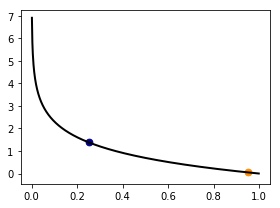

In [9]:

pwm_true = np.array([1., 0., 0., 0.])

p_ons = np.linspace(0.001, 0.999, 1000)

ces = []

for i in range(p_ons.shape[0]) :
    
    p_on = p_ons[i]
    p_off = 1. - p_on / 3.
    
    pwm_pred = np.array([p_on, p_off, p_off, p_off])
    
    ce = - np.sum(pwm_true * np.log(pwm_pred))
    ces.append(ce)

ces = np.array(ces)

f = plt.figure(figsize=(4, 3))

plt.plot(p_ons, ces, color='black', linewidth=2)

plt.scatter([0.25], [- np.sum(pwm_true * np.log(np.array([0.25, 0.25, 0.25, 0.25])))], c='darkblue', s=45)
plt.scatter([0.95], [- np.sum(pwm_true * np.log(np.array([0.95, 0.05/3., 0.05/3., 0.05/3.])))], c='darkorange', s=45)

plt.tight_layout()
plt.show()


In [10]:

def get_pwm_cross_entropy() :

    def _pwm_cross_entropy(inputs) :
        pwm_true, pwm_pred = inputs
        
        pwm_pred = K.clip(pwm_pred, K.epsilon(), 1. - K.epsilon())

        ce = - K.sum(pwm_true[:, 0, :, :] * K.log(pwm_pred[:, 0, :, :]), axis=-1)
        
        return K.expand_dims(K.mean(ce, axis=-1), axis=-1)
    
    return _pwm_cross_entropy

def min_pred(y_true, y_pred) :
    return y_pred

def get_weighted_loss(loss_coeff=1.) :
    
    def _min_pred(y_true, y_pred) :
        return loss_coeff * y_pred
    
    return _min_pred

def get_z_sample(z_inputs):
    
    z_mean, z_log_var = z_inputs
    
    batch_size = K.shape(z_mean)[0]
    latent_dim = K.int_shape(z_mean)[1]
    
    epsilon = K.random_normal(shape=(batch_size, latent_dim))
    
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def get_z_kl_loss() :
    
    def _z_kl_loss(inputs) :
        z_mean, z_log_var = inputs
        
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.mean(kl_loss, axis=-1)
        kl_loss *= -0.5
        
        return K.expand_dims(kl_loss, axis=-1)
    
    return _z_kl_loss


In [11]:
#Simple Library

sequence_templates = [
    'N' * 128
]


In [12]:
#Initialize Encoder and Decoder networks
batch_size = 32
seq_length = 128
n_samples = None
latent_size = 100

#Load Encoder
encoder = load_encoder_resnet(seq_length=seq_length, latent_size=latent_size)

#Load Decoder
decoder = load_decoder_resnet(seq_length=seq_length, latent_size=latent_size)

#Load Sampler
sampler = build_sampler(batch_size, seq_length, n_classes=1, n_samples=n_samples, validation_sample_mode='sample')


In [13]:
#Build Encoder Model
encoder_input = Input(shape=(1, seq_length, 4), name='encoder_input')

z_mean, z_log_var = encoder(encoder_input)

z_sampling_layer = Lambda(get_z_sample, output_shape=(latent_size,), name='z_sampler')
z = z_sampling_layer([z_mean, z_log_var])

# instantiate encoder model
encoder_model = Model(encoder_input, [z_mean, z_log_var, z])
encoder_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss=min_pred
)

#Build Decoder Model
decoder_class = Input(shape=(1,), name='decoder_class')
decoder_input = Input(shape=(latent_size,), name='decoder_input')

pwm_logits, pwm, sampled_pwm = sampler(decoder_class, decoder(decoder_input))

decoder_model = Model([decoder_class, decoder_input], [pwm_logits, pwm, sampled_pwm])

#Initialize Sequence Templates and Masks
initialize_sequence_templates(decoder_model, sequence_templates)

decoder_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss=min_pred
)


In [14]:
#Build VAE Pipeline

vae_decoder_class = Input(shape=(1,), name='vae_decoder_class')
vae_encoder_input = Input(shape=(1, seq_length, 4), name='vae_encoder_input')

encoded_z_mean, encoded_z_log_var = encoder(vae_encoder_input)
encoded_z = z_sampling_layer([encoded_z_mean, encoded_z_log_var])
decoded_logits, decoded_pwm, decoded_sample = sampler(vae_decoder_class, decoder(encoded_z))

reconstruction_loss = Lambda(get_pwm_cross_entropy(), name='reconstruction')([vae_encoder_input, decoded_pwm])

kl_loss = Lambda(get_z_kl_loss(), name='kl')([encoded_z_mean, encoded_z_log_var])

vae_model = Model(
    [vae_decoder_class, vae_encoder_input],
    [reconstruction_loss, kl_loss]#, entropy_loss]
)

#Initialize Sequence Templates and Masks
initialize_sequence_templates(vae_model, sequence_templates)

vae_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    #optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss={
        'reconstruction' : get_weighted_loss(loss_coeff=1.),
        'kl' : get_weighted_loss(loss_coeff=0.25)#0.05#0.1#0.15#0.05#, #0.000001
        #'entropy' : get_weighted_loss(loss_coeff=0.0)
    }
)


In [15]:
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 1, 128, 4)    0                                            
__________________________________________________________________________________________________
policy_discriminator_conv_0 (Co (None, 1, 128, 32)   160         encoder_input[0][0]              
__________________________________________________________________________________________________
policy_discriminator_resblock_0 (None, 1, 128, 32)   128         policy_discriminator_conv_0[0][0]
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1, 128, 32)   0           policy_discriminator_resblock_0_0
__________________________________________________________________________________________________
policy_dis

In [16]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, 100)          0                                            
__________________________________________________________________________________________________
policy_generator_dense_0 (Dense (None, 2048)         206848      decoder_input[0][0]              
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 4, 512)    0           policy_generator_dense_0[0][0]   
__________________________________________________________________________________________________
policy_generator_resblock_0_0_b (None, 1, 4, 512)    2048        reshape_1[0][0]                  
__________________________________________________________________________________________________
lambda_9 (

In [17]:
n_epochs = 50#10

s_train = np.zeros((x_train.shape[0], 1))
s_test = np.zeros((x_test.shape[0], 1))

dummy_target_train = np.zeros((x_train.shape[0], 1))
dummy_target_test = np.zeros((x_test.shape[0], 1))

callbacks =[
    EarlyStopping(monitor='val_loss', min_delta=0.002, patience=10, verbose=0, mode='auto')
]

# train the autoencoder
train_history = vae_model.fit(
    [s_train, x_train],
    [dummy_target_train, dummy_target_train],#, dummy_target_train],
    shuffle=True,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(
        [s_test, x_test],
        [dummy_target_test, dummy_target_test]#, dummy_target_test]
    ),
    callbacks=callbacks
)


Train on 27936 samples, validate on 1536 samples
Epoch 1/50
27936/27936 [==============================] - 57s 2ms/step - loss: 1.3393 - reconstruction_loss: 1.2966 - kl_loss: 0.0427 - val_loss: 1.2697 - val_reconstruction_loss: 1.2267 - val_kl_loss: 0.0430
Epoch 2/50
27936/27936 [==============================] - 48s 2ms/step - loss: 1.2256 - reconstruction_loss: 1.1515 - kl_loss: 0.0741 - val_loss: 1.1946 - val_reconstruction_loss: 1.0939 - val_kl_loss: 0.1007
Epoch 3/50
27936/27936 [==============================] - 47s 2ms/step - loss: 1.1630 - reconstruction_loss: 1.0354 - kl_loss: 0.1276 - val_loss: 1.1329 - val_reconstruction_loss: 0.9826 - val_kl_loss: 0.1503
Epoch 4/50
27936/27936 [==============================] - 47s 2ms/step - loss: 1.0942 - reconstruction_loss: 0.9142 - kl_loss: 0.1800 - val_loss: 1.0604 - val_reconstruction_loss: 0.8525 - val_kl_loss: 0.2079
Epoch 5/50
27936/27936 [==============================] - 47s 2ms/step - loss: 1.0135 - reconstruction_loss: 0.7741

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27936/27936 [==============================] - 47s 2ms/step - loss: 0.7011 - reconstruction_loss: 0.2906 - kl_loss: 0.4105 - val_loss: 0.7084 - val_reconstruction_loss: 0.3006 - val_kl_loss: 0.4078
Epoch 18/50
27936/27936 [==============================] - 47s 2ms/step - loss: 0.6969 - reconstruction_loss: 0.2842 - kl_loss: 0.4127 - val_loss: 0.6871 - val_reconstruction_loss: 0.2712 - val_kl_loss: 0.4159
Epoch 19/50
27936/27936 [==============================] - 47s 2ms/step - loss: 0.6935 - reconstruction_loss: 0.2795 - kl_loss: 0.4139 - val_loss: 0.6871 - val_reconstruction_loss: 0.2720 - val_kl_loss: 0.4150
Epoch 20/50
15040/27936 [===============>..............] - ETA: 21s - loss: 0.6915 - reconstruction_loss: 0.2761 - kl_loss: 0.4154

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27936/27936 [==============================] - 47s 2ms/step - loss: 0.6817 - reconstruction_loss: 0.2625 - kl_loss: 0.4192 - val_loss: 0.6735 - val_reconstruction_loss: 0.2468 - val_kl_loss: 0.4268
Epoch 24/50
27936/27936 [==============================] - 47s 2ms/step - loss: 0.6779 - reconstruction_loss: 0.2580 - kl_loss: 0.4199 - val_loss: 0.6996 - val_reconstruction_loss: 0.2807 - val_kl_loss: 0.4189
Epoch 25/50
27936/27936 [==============================] - 47s 2ms/step - loss: 0.6759 - reconstruction_loss: 0.2550 - kl_loss: 0.4209 - val_loss: 0.6678 - val_reconstruction_loss: 0.2463 - val_kl_loss: 0.4215
Epoch 26/50
26016/27936 [==========================>...] - ETA: 3s - loss: 0.6732 - reconstruction_loss: 0.2518 - kl_loss: 0.4215

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27936/27936 [==============================] - 48s 2ms/step - loss: 0.6714 - reconstruction_loss: 0.2486 - kl_loss: 0.4228 - val_loss: 0.6724 - val_reconstruction_loss: 0.2481 - val_kl_loss: 0.4243
Epoch 28/50
27936/27936 [==============================] - 47s 2ms/step - loss: 0.6695 - reconstruction_loss: 0.2456 - kl_loss: 0.4238 - val_loss: 0.6604 - val_reconstruction_loss: 0.2443 - val_kl_loss: 0.4162
Epoch 29/50
27936/27936 [==============================] - 47s 2ms/step - loss: 0.6667 - reconstruction_loss: 0.2424 - kl_loss: 0.4243 - val_loss: 0.6894 - val_reconstruction_loss: 0.2583 - val_kl_loss: 0.4311
Epoch 30/50
27936/27936 [==============================] - 47s 2ms/step - loss: 0.6646 - reconstruction_loss: 0.2395 - kl_loss: 0.4251 - val_loss: 0.6604 - val_reconstruction_loss: 0.2367 - val_kl_loss: 0.4237
Epoch 31/50
27936/27936 [==============================] - 47s 2ms/step - loss: 0.6627 - reconstruction_loss: 0.2367 - kl_loss: 0.4260 - val_loss: 0.6751 - val_reconstructi

In [24]:
n_epochs = 20#10

callbacks =[
    EarlyStopping(monitor='val_loss', min_delta=0.002, patience=10, verbose=0, mode='auto')
]

# train the autoencoder
train_history = vae_model.fit(
    [s_train, x_train],
    [dummy_target_train, dummy_target_train],#, dummy_target_train],
    shuffle=True,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(
        [s_test, x_test],
        [dummy_target_test, dummy_target_test]#, dummy_target_test]
    ),
    callbacks=callbacks
)


Train on 27936 samples, validate on 1536 samples
Epoch 1/20
27936/27936 [==============================] - 48s 2ms/step - loss: 0.6042 - reconstruction_loss: 0.1425 - kl_loss: 0.4618 - val_loss: 0.6106 - val_reconstruction_loss: 0.1487 - val_kl_loss: 0.4618
Epoch 2/20
27936/27936 [==============================] - 48s 2ms/step - loss: 0.6016 - reconstruction_loss: 0.1390 - kl_loss: 0.4625 - val_loss: 0.6041 - val_reconstruction_loss: 0.1392 - val_kl_loss: 0.4648
Epoch 3/20
27936/27936 [==============================] - 48s 2ms/step - loss: 0.5994 - reconstruction_loss: 0.1357 - kl_loss: 0.4637 - val_loss: 0.5953 - val_reconstruction_loss: 0.1276 - val_kl_loss: 0.4678
Epoch 4/20
27936/27936 [==============================] - 48s 2ms/step - loss: 0.5973 - reconstruction_loss: 0.1325 - kl_loss: 0.4647 - val_loss: 0.5991 - val_reconstruction_loss: 0.1351 - val_kl_loss: 0.4640
Epoch 5/20
27936/27936 [==============================] - 48s 2ms/step - loss: 0.5947 - reconstruction_loss: 0.1295

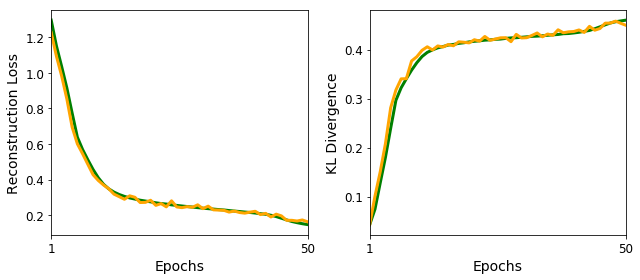

In [18]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.5 * 2, 4))

n_epochs_actual = len(train_history.history['reconstruction_loss'])

ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['reconstruction_loss'], linewidth=3, color='green')
ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_reconstruction_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Reconstruction Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['kl_loss'], linewidth=3, color='green')
ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_kl_loss'], linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("KL Divergence", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


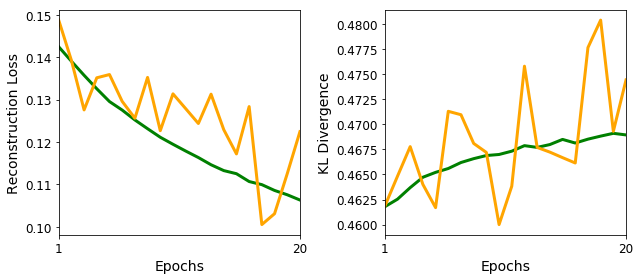

In [30]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.5 * 2, 4))

n_epochs_actual = len(train_history.history['reconstruction_loss'])

ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['reconstruction_loss'], linewidth=3, color='green')
ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_reconstruction_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Reconstruction Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['kl_loss'], linewidth=3, color='green')
ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_kl_loss'], linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("KL Divergence", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [25]:
# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'vae_apa_max_isoform_apadb_new_resnet_fixed_70_epochs_encoder_128_strided_encoder_strict_pas_only.h5'
model_path = os.path.join(save_dir, model_name)
encoder_model.save(model_path)
print('Saved trained model at %s ' % model_path)

model_name = 'vae_apa_max_isoform_apadb_new_resnet_fixed_70_epochs_decoder_128_strided_encoder_strict_pas_only.h5'
model_path = os.path.join(save_dir, model_name)
decoder_model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at saved_models/vae_apa_max_isoform_apadb_new_resnet_fixed_70_epochs_encoder_128_strided_encoder_strict_pas_only.h5 
Saved trained model at saved_models/vae_apa_max_isoform_apadb_new_resnet_fixed_70_epochs_decoder_128_strided_encoder_strict_pas_only.h5 


In [17]:
#Load models
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'vae_apa_max_isoform_apadb_new_resnet_fixed_70_epochs_encoder_128_strided_encoder_strict_pas_only.h5'
model_path = os.path.join(save_dir, model_name)
encoder_model = load_model(model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred})

model_name = 'vae_apa_max_isoform_apadb_new_resnet_fixed_70_epochs_decoder_128_strided_encoder_strict_pas_only.h5'
model_path = os.path.join(save_dir, model_name)
decoder_model = load_model(model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred})


Test sequence 0:


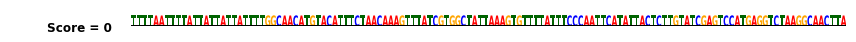

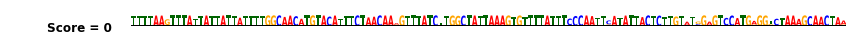

Test sequence 1:


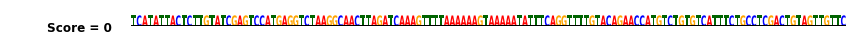

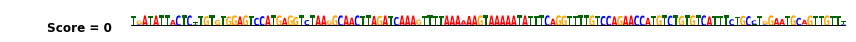

Test sequence 2:


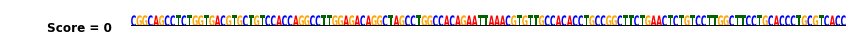

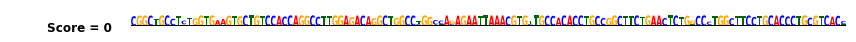

Test sequence 3:


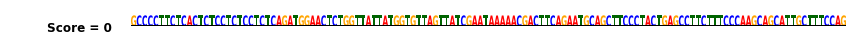

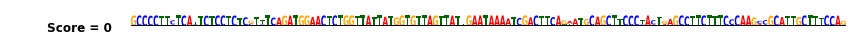

Test sequence 4:


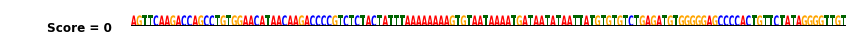

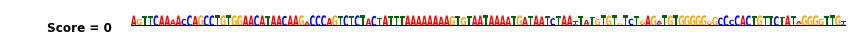

In [18]:
#Visualize a few fake and real sequence patterns

s_test = np.zeros((x_test.shape[0], 1))

z_mean_test, z_log_var_test, z_test = encoder_model.predict_on_batch([x_test[:32]])

fake_pwm_test_batch = decoder_model.predict_on_batch([s_test[:32], z_test[:32]])

for plot_i in range(5) :
    print("Test sequence " + str(plot_i) + ":")
    plot_gan_logo(x_test[plot_i, 0, :, :], 0, sequence_template=('N' * 128), figsize=(12, 0.55), width_ratios=[1, 7], logo_height=1.0, plot_start=0, plot_end=128)
    plot_gan_logo(fake_pwm_test_batch[1][plot_i, 0, :, :], 0, sequence_template=('N' * 128), figsize=(12, 0.55), width_ratios=[1, 7], logo_height=1.0, plot_start=0, plot_end=128)


- Fake PWMs (Randomly Generated) -


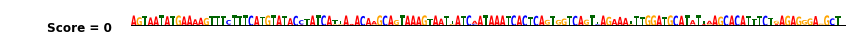

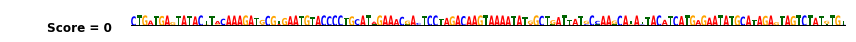

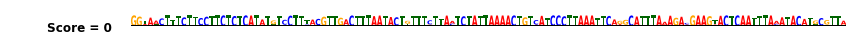

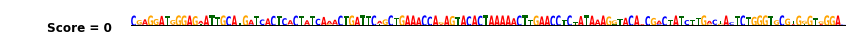

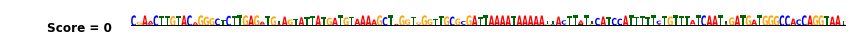

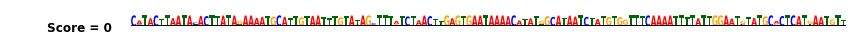

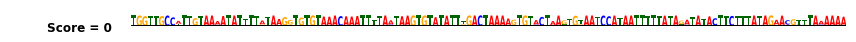

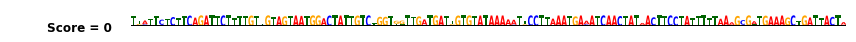

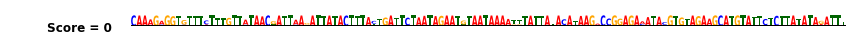

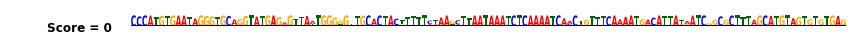

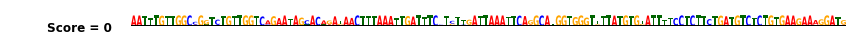

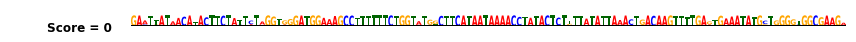

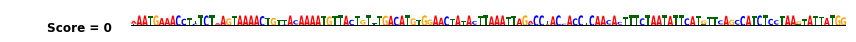

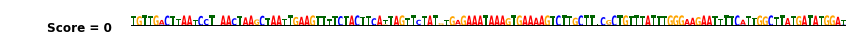

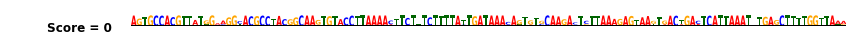

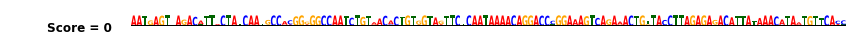

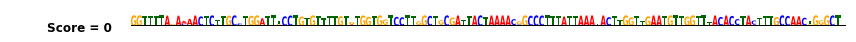

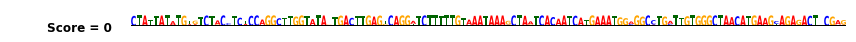

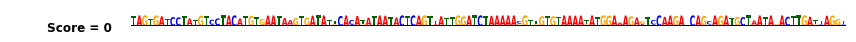

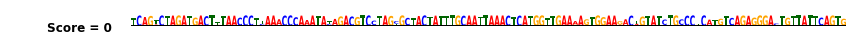

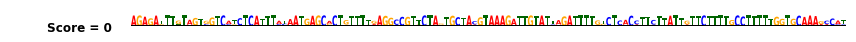

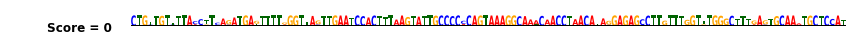

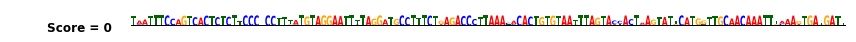

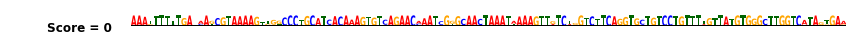

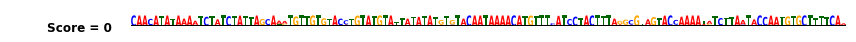

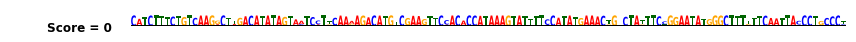

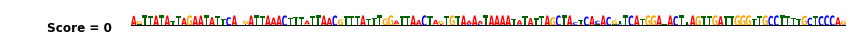

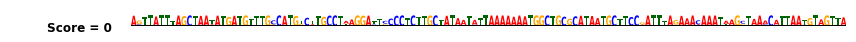

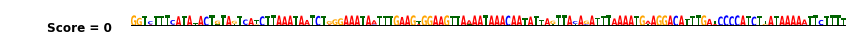

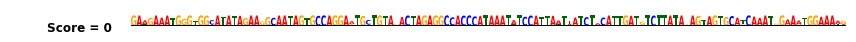

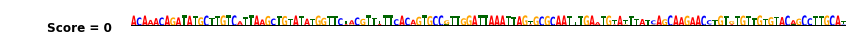

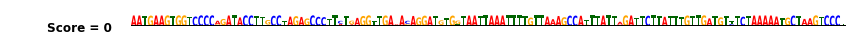

In [41]:
#Sample new patterns

z_test_new = np.random.normal(loc=0.0, scale=1.0, size=(32, 100))

fake_pwm_test_batch = decoder_model.predict_on_batch([s_test[:32], z_test_new[:32]])

print("- Fake PWMs (Randomly Generated) -")

for plot_i in range(32) :
    plot_gan_logo(fake_pwm_test_batch[1][plot_i, 0, :, :], 0, sequence_template=('N' * 128), figsize=(12, 0.55), width_ratios=[1, 7], logo_height=1.0, plot_start=0, plot_end=128)


In [30]:
from scipy.stats import norm

np.log(np.mean(np.prod(norm.pdf(z_test_new), axis=-1)))


-136.10486708455815

In [31]:
from scipy.stats import norm

np.log(np.mean(np.prod(norm.pdf(z_test), axis=-1)))


-139.50345745342864